## 1. Imports and Paths

In [1]:
# Playing with labeled image data
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from kp_descriptor_fns import HarrisKeypointDetector, SimpleFeatureDescriptor, ORBFeatureDescriptor, SIFTFeatureDescriptor

In [2]:
# Define directories
base_dir = '/Users/jetcalz07/Desktop/MIDS/W281_CV/logo_detection_w281/'
image_dir = base_dir + 'data/images/'
bbox_dir = base_dir + 'data/yolofinalset/obj_train_data/'
ref_dir = base_dir + 'data/logo_references/adidas/'

## 2. Load Example for Dev

In [3]:
# Load list of train images
with open(base_dir + 'data/yolofinalset/train.txt') as f:
    train = f.readlines()
train = [x.replace('\n', '').split('/')[-1] for x in train]

# Load adidas image, template, bounding boxes
z = 0
img_file = image_dir + train[z]
ref_file = ref_dir + os.listdir(ref_dir)[0] 
img_bbox = bbox_dir +  train[z].replace('.jpg', '.txt')

# Read in image and bounding box info, format
im = plt.imread(img_file)
im_gray = im[:, :, 0].copy()
with open(img_bbox) as f:
    ls = f.readlines()

lines = []
for l in ls:
    l = l.replace('\n', '')
    l = l.split(' ')
    lines.append(list(map(float, l)))

## 3. Given image, bbox info.. extract the bounding boxes

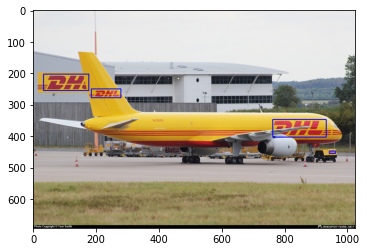

In [4]:
# Extract bbox subset from image for feature extraction
def extract_bboxes(img):
    y_shape, x_shape = img.shape[:2]
    img_copy = img.copy()

    bboxes = [] # determine bbox locations
    for l in lines:
        middle_x = int(x_shape*l[1])
        middle_y = int(y_shape*l[2])
        l_x = middle_x - int(x_shape*l[3]/2)
        r_x = middle_x + int(x_shape*l[3]/2)
        b_y = middle_y + int(y_shape*l[4]/2)
        t_y = middle_y - int(y_shape*l[4]/2)
        draw_rect = cv2.rectangle(img_copy, (l_x, t_y), (r_x, b_y), (0,0,255), 2)
        bboxes.append([l_x, r_x, t_y, b_y]) # save out the bbox corners
    
    plt.imshow(img_copy)
    return bboxes

bboxes = extract_bboxes(im)


#### 3.1 View each box for image

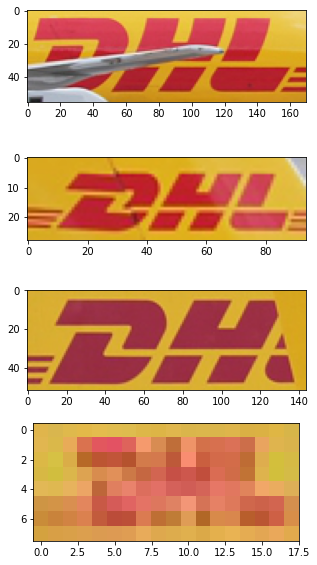

In [5]:
# Extract a single box so that we can extract features
fig, ax = plt.subplots(len(bboxes), 1, figsize=(5, 10))

for i in range(len(bboxes)):
    x_min, x_max, y_min, y_max = bboxes[i]
    img_bbox = im[y_min:y_max, x_min:x_max, :]
    ax[i].imshow(img_bbox)

## 4. Feature Extraction - Harris Corners

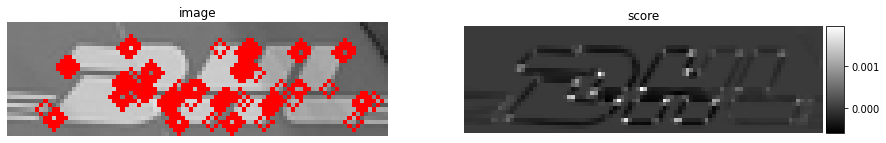

Total keypoints detected: 86


In [6]:
# Extract a single box so that we can extract features
i = 1 # box number
x_min, x_max, y_min, y_max = bboxes[i]
img_bbox = im[y_min:y_max, x_min:x_max, :]

# Get harris corners
gray_bbox = cv2.cvtColor(img_bbox, cv2.COLOR_BGR2GRAY)
kp = HarrisKeypointDetector(gray_bbox, n=2)
print(f"Total keypoints detected: {len(kp)}")

In [7]:
##  Use corner keypoints to derive descriptor features
# simple feature is just the pixel values in 5x5 surrounding window
simple_feature = SimpleFeatureDescriptor(gray_bbox, kp, w=3)
simple_feature.shape

(86, 9)

In [30]:
def ORBFeatureDescriptor(grayImage, harris_kp, use_harris=True, nfeatures=10):
    orb = cv2.ORB_create(nfeatures, edgeThreshold=2) # edgeThresh tells orb not to look within x pixels of border
    if use_harris:
        kp, des = orb.compute(grayImage, harris_kp) # use harris corners
    else:
        kp, des = orb.detectandcompute(grayImage, None) # or use orb keypoints
    return des
    
    
##  Use corner keypoints to derive descriptor features
# ORB is scale invariant (looks for keypoints in resolution pyramid), and rotation invariant
# The descriptor is difficult to articulate but it learns how the pixel intensity fluctuates within a region around keypoint
orb_feature = ORBFeatureDescriptor(gray_bbox, kp)
print(len(orb_feature))
print(np.max(orb_feature))

86
255


In [34]:
##  Use corner keypoints to derive descriptor features
def SIFTFeatureDescriptor(grayImage, harris_kp, use_harris=True, nfeatures=10):
    orb = cv2.SIFT_create(nfeatures, edgeThreshold=2)
    if use_harris:
        kp, des = orb.compute(grayImage, harris_kp) # use harris corners
    else:
        kp, des = orb.detectandcompute(grayImage, None) # or use orb keypoints
    return des

sift_feature = SIFTFeatureDescriptor(gray_bbox, kp)
print(len(orb_feature))
print(np.max(orb_feature))

86
255
